In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import click
import os
import sys
import json
import requests
from requests_helper import branch_to_hash, post_analyze, get_results, get_status
from git import Repo, GitCommandError
import git
import subprocess
from github import Github
import tempfile
import shutil
import random

user_token = os.getenv('MUSEDEV_TOKEN')
gh_token = os.getenv('GH_GITHUB_API_TOKEN')
g = Github(gh_token)

In [4]:
with open("../go-repos.txt") as f:
    repo_list = [x.strip() for x in f.readlines()]

In [7]:
repo_list[:5]

['zhshch2002/goribot',
 'axiomhq/hyperloglog',
 'tornadoweb/tornado',
 'VividCortex/pm',
 'clipperhouse/gen']

In [346]:
def analyze(repo):
    (owner,name) = repo.full_name.split("/")
    commit = branch_to_hash(owner, name, repo.default_branch)
    return post_analyze(user_token, owner, name, commit).strip("\"")

def status(job_id):
    return get_status(user_token, job_id)

def job_complete(job_id):
    status = get_status(user_token, job_id)
    return "Complete" in status

def results(job_id):
    return get_results(user_token, job_id)

In [347]:
def fork(repo):
    user = g.get_user()
    my_fork = user.create_fork(repo)
    return my_fork

def add_muse_config(repo):
    try:
        user = g.get_user()
        repo_dir = tempfile.gettempdir() + "/" + str(repo.name)
        if os.path.exists(repo_dir) and os.path.isdir(repo_dir):
            shutil.rmtree(repo_dir)
        local_repo = Repo.clone_from("git@github.com:" + str(user.login) + "/" + str(repo.name) + ".git",
                                     repo_dir, branch="master")
        target_dir = repo_dir + "/.muse"
        if os.path.exists(target_dir):
            shutil.rmtree(target_dir)
        shutil.copytree(os.getcwd() + '/../.muse', target_dir)
        local_repo.git.add(target_dir)
        local_repo.git.commit('-m', 'Adding Muse config')
        origin = local_repo.remote(name='origin')
        origin.push()
    except GitCommandError:
        print("Directory already exists and is not empty. Not cloning.")
        pass

In [348]:
def setup(repo):
    f = fork(repo)
    add_muse_config(f)
    return f

In [414]:
def analyze_list(repos):
    results = list()
    for r in repos:
        print("Setting up "+str(r))
        fork_w_config = setup(r)
        print("Starting analysis")
        jobid = analyze(fork_w_config)
        results.append({'repo':r, 'fork':fork_w_config, 'jobid':jobid})
    return pd.DataFrame(results)

def filter_result(r,keys):
    result = dict()
    for (k,v) in r.items():
        if k in keys:
            result[k] = v
    return result

def static_check_results(j):
    try:
        result_json = results(j)
        result_list = list()
        for res in result_json:
            if res[0][0]['tag'] == 'CustomTool' and res[0][0]['contents'] == '.muse/staticcheck.sh':
                for note in res[1]['ToolResultSuccess']['toolNotes']:
                    result_list.append(filter_result(note,["tnFile","tnLine","tnType","tnDesc"]))
        return result_list
    except:
        return list()

def show_bug_types(results):
    types = set()
    for res in results:
        types.add(res['tnType'])
    return types

In [350]:
dataset = analyze_list(sample)

Setting up Repository(full_name="zhshch2002/goribot")
Directory already exists and is not empty. Not cloning.
Starting analysis
Setting up Repository(full_name="axiomhq/hyperloglog")
Directory already exists and is not empty. Not cloning.
Starting analysis
Setting up Repository(full_name="tornadoweb/tornado")
Directory already exists and is not empty. Not cloning.
Starting analysis
Setting up Repository(full_name="VividCortex/pm")
Directory already exists and is not empty. Not cloning.
Starting analysis
Setting up Repository(full_name="clipperhouse/gen")
Directory already exists and is not empty. Not cloning.
Starting analysis
Setting up Repository(full_name="xis/baraka")
Directory already exists and is not empty. Not cloning.
Starting analysis
Setting up Repository(full_name="toorop/go-dkim")
Directory already exists and is not empty. Not cloning.
Starting analysis
Setting up Repository(full_name="recoilme/pudge")
Directory already exists and is not empty. Not cloning.
Starting analys

In [351]:
dataset['jobid'].apply(status)

0     "JobCompleteSuccess"
1     "JobCompleteSuccess"
2     "JobCompleteSuccess"
3     "JobCompleteSuccess"
4     "JobCompleteSuccess"
5     "JobCompleteSuccess"
6     "JobCompleteSuccess"
7     "JobCompleteSuccess"
8     "JobCompleteSuccess"
9     "JobCompleteSuccess"
10    "JobCompleteSuccess"
11    "JobCompleteSuccess"
12    "JobCompleteSuccess"
13    "JobCompleteSuccess"
14    "JobCompleteSuccess"
15    "JobCompleteSuccess"
16    "JobCompleteSuccess"
17    "JobCompleteSuccess"
18    "JobCompleteSuccess"
19    "JobCompleteSuccess"
20    "JobCompleteSuccess"
21    "JobCompleteSuccess"
22    "JobCompleteSuccess"
23    "JobCompleteSuccess"
24    "JobCompleteSuccess"
25    "JobCompleteSuccess"
26    "JobCompleteSuccess"
27    "JobCompleteSuccess"
28    "JobCompleteSuccess"
29    "JobCompleteSuccess"
30    "JobCompleteSuccess"
31    "JobCompleteSuccess"
32    "JobCompleteSuccess"
33    "JobCompleteSuccess"
34    "JobCompleteSuccess"
35    "JobCompleteSuccess"
36    "JobCompleteSuccess"
3

In [415]:
dataset['jobid'].apply(lambda j: show_bug_types(static_check_results(j)))

0                         {SA4006, S1005, S1002, S1028}
1                                                    {}
2                                                    {}
3                                               {S1005}
4                        {S1007, ST1005, U1000, SA4006}
5                                       {S1008, SA5001}
6               {compile, ST1005, S1003, S1023, SA4006}
7                  {S1019, ST1005, S1004, S1023, S1034}
8                                                    {}
9                         {S1008, ST1005, S1034, S1004}
10        {S1008, ST1005, S1001, U1000, SA1016, ST1006}
11    {SA1029, S1009, U1000, SA6002, S1010, S1034, S...
12                              {S1023, compile, S1021}
13                                            {compile}
14                                                   {}
15                 {U1000, SA4011, S1006, S1003, S1028}
16                               {S1025, U1000, SA4006}
17                              {ST1005, U1000, 

In [421]:
(dataset['results'].apply(show_bug_types) != set()).sum()

39

In [353]:
static_check_results(dataset['jobid'][0])

[{'tnFile': 'goribot.go',
  'tnLine': 94,
  'tnType': 'S1002',
  'tnDesc': 'should omit comparison to bool constant, can be simplified to !s.AutoStop'},
 {'tnFile': 'goribot.go',
  'tnLine': 157,
  'tnType': 'S1028',
  'tnDesc': 'should use fmt.Errorf(...) instead of errors.New(fmt.Sprintf(...))'},
 {'tnFile': 'goribot.go',
  'tnLine': 173,
  'tnType': 'S1002',
  'tnDesc': 'should omit comparison to bool constant, can be simplified to !s.AutoStop'},
 {'tnFile': 'goribot.go',
  'tnLine': 193,
  'tnType': 'S1028',
  'tnDesc': 'should use fmt.Errorf(...) instead of errors.New(fmt.Sprintf(...))'},
 {'tnFile': 'goribot.go',
  'tnLine': 233,
  'tnType': 'S1005',
  'tnDesc': 'unnecessary assignment to the blank identifier'},
 {'tnFile': 'goribot.go',
  'tnLine': 235,
  'tnType': 'S1005',
  'tnDesc': 'unnecessary assignment to the blank identifier'},
 {'tnFile': 'limiter.go',
  'tnLine': 68,
  'tnType': 'S1005',
  'tnDesc': 'unnecessary assignment to the blank identifier'},
 {'tnFile': 'manage

In [354]:
dataset['results'] = dataset['jobid'].apply(static_check_results)

In [386]:
dataset['repo_name'] = dataset['repo'].apply(lambda x: x.full_name)

In [356]:
dataset.head()

,fork,jobid,repo,results,repo_name
0,"Repository(full_name=""smagill/goribot"")",01EJ9DWV9CHVN9RXWJMN4QXPS2,"Repository(full_name=""zhshch2002/goribot"")","[{'tnFile': 'goribot.go', 'tnLine': 94, 'tnTyp...",zhshch2002/goribot
1,"Repository(full_name=""smagill/hyperloglog"")",01EJ9DWWHB1HA9GBP3CN0XP92X,"Repository(full_name=""axiomhq/hyperloglog"")",[],axiomhq/hyperloglog
2,"Repository(full_name=""smagill/tornado"")",01EJ9DX16ZRTZEQV00JF7YYYW8,"Repository(full_name=""tornadoweb/tornado"")",[],tornadoweb/tornado
3,"Repository(full_name=""smagill/pm"")",01EJ9DX2CHZH3RFSW83QD75RBT,"Repository(full_name=""VividCortex/pm"")","[{'tnFile': 'cli/pm-cli.go', 'tnLine': 112, 't...",VividCortex/pm
4,"Repository(full_name=""smagill/gen"")",01EJ9DX52288FQ4FRCFED0THGF,"Repository(full_name=""clipperhouse/gen"")","[{'tnFile': 'add_test.go', 'tnLine': 37, 'tnTy...",clipperhouse/gen


In [357]:
data = list(map(lambda x: x['tnType'], dataset['results'][0]))
data

['S1002', 'S1028', 'S1002', 'S1028', 'S1005', 'S1005', 'S1005', 'SA4006']

(array([2., 0., 0., 2., 0., 0., 3., 0., 0., 1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

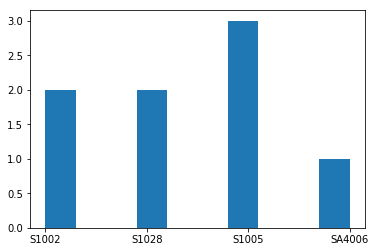

In [358]:
plt.hist(data)

In [359]:
dataset['num_bugs'] = dataset['results'].apply(len)

In [424]:
(dataset['num_bugs'] < 20).sum()

42

In [360]:
dataset.head()

,fork,jobid,repo,results,repo_name,num_bugs
0,"Repository(full_name=""smagill/goribot"")",01EJ9DWV9CHVN9RXWJMN4QXPS2,"Repository(full_name=""zhshch2002/goribot"")","[{'tnFile': 'goribot.go', 'tnLine': 94, 'tnTyp...",zhshch2002/goribot,8
1,"Repository(full_name=""smagill/hyperloglog"")",01EJ9DWWHB1HA9GBP3CN0XP92X,"Repository(full_name=""axiomhq/hyperloglog"")",[],axiomhq/hyperloglog,0
2,"Repository(full_name=""smagill/tornado"")",01EJ9DX16ZRTZEQV00JF7YYYW8,"Repository(full_name=""tornadoweb/tornado"")",[],tornadoweb/tornado,0
3,"Repository(full_name=""smagill/pm"")",01EJ9DX2CHZH3RFSW83QD75RBT,"Repository(full_name=""VividCortex/pm"")","[{'tnFile': 'cli/pm-cli.go', 'tnLine': 112, 't...",VividCortex/pm,1
4,"Repository(full_name=""smagill/gen"")",01EJ9DX52288FQ4FRCFED0THGF,"Repository(full_name=""clipperhouse/gen"")","[{'tnFile': 'add_test.go', 'tnLine': 37, 'tnTy...",clipperhouse/gen,9


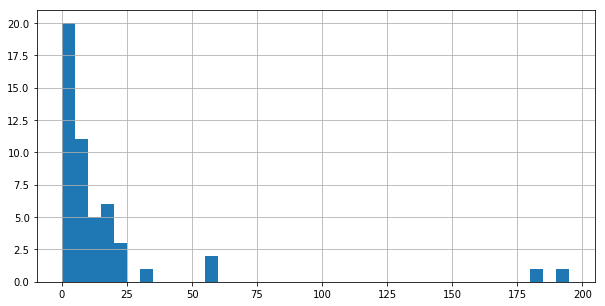

In [361]:
dataset['num_bugs'].hist(bins=range(0,dataset['num_bugs'].max()+5,5),figsize=(10,5))

In [362]:
dataset[dataset['num_bugs'] > 100]

,fork,jobid,repo,results,repo_name,num_bugs
10,"Repository(full_name=""smagill/gostorm"")",01EJ9DXF462ZEVSWZ1YFCVRPTR,"Repository(full_name=""jsgilmore/gostorm"")","[{'tnFile': 'core/conns.go', 'tnLine': 70, 'tn...",jsgilmore/gostorm,195
31,"Repository(full_name=""smagill/tendermint"")",01EJ9E1DB0NDN9D8ZWFSQYB860,"Repository(full_name=""tendermint/tendermint"")",[{'tnFile': 'abci/client/socket_client_test.go...,tendermint/tendermint,180


In [363]:
def count_type(ty,lst):
    def has_right_type(x):
        return x['tnType'].startswith(ty)
    return len(list(filter(has_right_type, lst)))

dataset['simplifications'] = \
    dataset['results'].apply(lambda x: count_type("S1",x))
dataset['library misuses'] = \
    dataset['results'].apply(lambda x: count_type("SA1",x))
dataset['concurrency'] = \
    dataset['results'].apply(lambda x: count_type("SA2",x))
dataset['testing'] = \
    dataset['results'].apply(lambda x: count_type("SA3",x))
dataset['useless code'] = \
    dataset['results'].apply(lambda x: count_type("SA4",x))
dataset['correctness'] = \
    dataset['results'].apply(lambda x: count_type("SA5",x))
dataset['performance'] = \
    dataset['results'].apply(lambda x: count_type("SA6",x))
dataset['dubious constructs'] = \
    dataset['results'].apply(lambda x: count_type("SA9",x))
dataset['style issues'] = \
    dataset['results'].apply(lambda x: count_type("ST",x))

bug_types = ['simplifications','concurrency','testing','useless code',
             'correctness','performance','dubious constructs','style issues']

In [364]:
dataset.head()

,fork,jobid,repo,results,repo_name,num_bugs,simplifications,library misuses,concurrency,testing,useless code,correctness,performance,dubious constructs,style issues
0,"Repository(full_name=""smagill/goribot"")",01EJ9DWV9CHVN9RXWJMN4QXPS2,"Repository(full_name=""zhshch2002/goribot"")","[{'tnFile': 'goribot.go', 'tnLine': 94, 'tnTyp...",zhshch2002/goribot,8,7,0,0,0,1,0,0,0,0
1,"Repository(full_name=""smagill/hyperloglog"")",01EJ9DWWHB1HA9GBP3CN0XP92X,"Repository(full_name=""axiomhq/hyperloglog"")",[],axiomhq/hyperloglog,0,0,0,0,0,0,0,0,0,0
2,"Repository(full_name=""smagill/tornado"")",01EJ9DX16ZRTZEQV00JF7YYYW8,"Repository(full_name=""tornadoweb/tornado"")",[],tornadoweb/tornado,0,0,0,0,0,0,0,0,0,0
3,"Repository(full_name=""smagill/pm"")",01EJ9DX2CHZH3RFSW83QD75RBT,"Repository(full_name=""VividCortex/pm"")","[{'tnFile': 'cli/pm-cli.go', 'tnLine': 112, 't...",VividCortex/pm,1,1,0,0,0,0,0,0,0,0
4,"Repository(full_name=""smagill/gen"")",01EJ9DX52288FQ4FRCFED0THGF,"Repository(full_name=""clipperhouse/gen"")","[{'tnFile': 'add_test.go', 'tnLine': 37, 'tnTy...",clipperhouse/gen,9,1,0,0,0,1,0,0,0,6


In [365]:
dataset[bug_types].sum()

simplifications       224
concurrency             0
testing                 2
useless code           47
correctness             8
performance             4
dubious constructs      6
style issues          225
dtype: int64

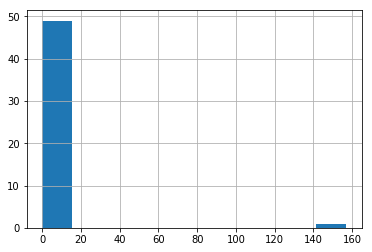

In [366]:
dataset['style issues'].hist()

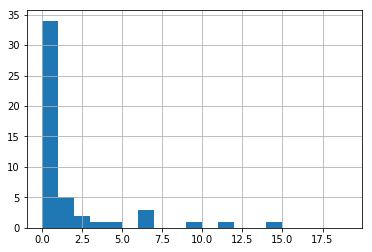

In [367]:
dataset['style issues'].hist(bins=range(0,20))

In [369]:
dataset[['repo_name','style issues']]

,repo_name,style issues
0,zhshch2002/goribot,0
1,axiomhq/hyperloglog,0
2,tornadoweb/tornado,0
3,VividCortex/pm,0
4,clipperhouse/gen,6
5,xis/baraka,0
6,toorop/go-dkim,2
7,recoilme/pudge,1
8,e-dard/netbug,0
9,plar/go-adaptive-radix-tree,2


In [371]:
dataset[dataset['style issues'] > 0][['repo_name','style issues']]

,repo_name,style issues
4,clipperhouse/gen,6
6,toorop/go-dkim,2
7,recoilme/pudge,1
9,plar/go-adaptive-radix-tree,2
10,jsgilmore/gostorm,157
17,shomali11/slacker,4
18,stellar/kelp,6
19,wellington/go-libsass,11
21,olebedev/go-duktape,1
23,zimmski/go-mutesting,3


(array([24.,  2.,  3.,  1.,  2.,  3.,  1.,  0.,  2.,  1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

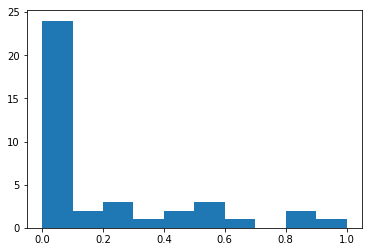

In [377]:
plt.hist(dataset['style issues'] / dataset['num_bugs'])

In [378]:
dataset['style ratio'] =  dataset['style issues'] / dataset['num_bugs']

In [380]:
dataset[dataset['style ratio'] > 0.5][['repo_name','style issues','num_bugs']]

,repo_name,style issues,num_bugs
4,clipperhouse/gen,6,9
10,jsgilmore/gostorm,157,195
17,shomali11/slacker,4,5
19,wellington/go-libsass,11,19
33,ziutek/kasia.go,9,17
41,commander-cli/cmd,1,1


In [391]:
dataset[dataset['repo_name'] == 'tendermint/tendermint'][bug_types]

,simplifications,concurrency,testing,useless code,correctness,performance,dubious constructs,style issues
31,49,0,0,6,0,0,0,0


In [406]:
show_bug_types(dataset[dataset['repo_name'] == 'tendermint/tendermint']['results'].values[0])

{'S1023', 'SA4011', 'U1000', 'compile'}

In [408]:
dataset[dataset['repo_name'] == 'tendermint/tendermint']['results'].values[0]

[{'tnFile': 'abci/client/socket_client_test.go',
  'tnLine': 22,
  'tnType': 'compile',
  'tnDesc': 't.Cleanup undefined (type *testing.T has no field or method Cleanup)'},
 {'tnFile': 'abci/client/socket_client_test.go',
  'tnLine': 27,
  'tnType': 'compile',
  'tnDesc': 't.Cleanup undefined (type *testing.T has no field or method Cleanup)'},
 {'tnFile': 'abci/client/socket_client_test.go',
  'tnLine': 57,
  'tnType': 'compile',
  'tnDesc': 't.Cleanup undefined (type *testing.T has no field or method Cleanup)'},
 {'tnFile': 'abci/client/socket_client_test.go',
  'tnLine': 62,
  'tnType': 'compile',
  'tnDesc': 't.Cleanup undefined (type *testing.T has no field or method Cleanup)'},
 {'tnFile': 'abci/example/example_test.go',
  'tnLine': 59,
  'tnType': 'compile',
  'tnDesc': 't.Cleanup undefined (type *testing.T has no field or method Cleanup)'},
 {'tnFile': 'abci/example/example_test.go',
  'tnLine': 71,
  'tnType': 'compile',
  'tnDesc': 't.Cleanup undefined (type *testing.T has no 